# NHP7 - Non-human primate data visualize task block structure (exploratory subject only)

## Takuya Ito
#### 12/7/2019

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import multiprocessing as mp
import scipy.stats as stats
os.environ['OMP_NUM_THREADS'] = str(1)
import statsmodels.api as sm
import statsmodels.sandbox.stats.multicomp as mc
import seaborn as sns
plt.style.use("ggplot")
sns.set_style('whitegrid')
plt.rcParams["font.family"] = "FreeSans"
import pandas as pd
import sys
import h5py
import statsmodels.api as sm
import analysisNHP as analysis


# Set up data parameters

In [2]:
## All sessions (both subjects included)
sessions = ['100706','100730','100804','100820','100827','100913','100921','101024','101122','101128',
            '101207','101217','110110_01','110115_01','100724','100731','100817','100823','100828',
            '100915','101008','101027','101123','101202','101209','110106','110110_02','110120','100725',
            '100802','100818','100824','100907','100917','101009','101028','101124','101203','101210',
            '110107_01','110111_01','110121','100726','100803','100819','100826','100910','100920','101023',
            '101030','101127','101206','101216','110107_02','110111_02']

datadir = '/projects3/TaskFCMech/data/nhpData/'
tmin = -4000 # in ms
tmax = 4000 # in ms, this was my own doing

# Load in monkeyIDs
idfile = datadir + 'monkeyToSessionID.csv'
monkeyTable = pd.read_csv(idfile,delimiter=',')

replication_sessions = 0
monkeyID = {}
for i in range(1, len(sessions)+1):
    if i < 10:
        sess_str = 'session_ ' + str(i)
        name_str = 'name_ '  + str(i)
    else:
        sess_str = 'session_' + str(i)
        name_str = 'name_'  + str(i)
    
    session = str(monkeyTable[sess_str][0])
    name = monkeyTable[name_str][0]

    if name=='paula':
        replication_sessions += 1
        
    if session=='110111_02.mat': session = '110111_02'
        
    monkeyID[session] = name
    
exploratory_sessions = len(sessions) - replication_sessions
print 'Number of sessions with exploratory subject:', exploratory_sessions 
print 'Number of sessions with replication subject', replication_sessions
    
regions = ['PFC', 'FEF', 'LIP', 'MT', 'IT', 'V4']

Number of sessions with exploratory subject: 16
Number of sessions with replication subject 39


# 1.0 Load all sessions for exploratory subject

#### Load other meta-data associated with neurons + task info

#### Compute downsampled firing rate using 50ms bins and 10ms shift

# Perform main analyses for exploratory subject

In [268]:
session = '101127'
# session = '110107_01'
taskInfo = pd.read_csv(datadir + session + '_trialInfoAllTasks.csv')
mocolTrials = np.where(taskInfo['task']=='mocol')[0]
mocolInfo = pd.read_csv(datadir + session + '_trialInfoMOCOL.csv')
areas = pd.read_csv(datadir + session + '_areaIndices_v2.csv')
h5f = h5py.File(datadir + session + '_perArea_v2.h5', 'r')
roi = 3
task = 'motion'

# Identify trials for specific task condition
tasksByTrial = mocolInfo['rule'].astype(str)
task_ind = np.where(tasksByTrial==task)[0]
correct_ind = np.where(mocolInfo.correct==1)[0]
task_ind = np.intersect1d(task_ind,correct_ind)

# Columns for h5f are reversed between matlab and python
spikes_binned = analysis.slidingWindow(h5f['sta'][mocolTrials,:,roi].T,binSize=50,shiftSize=10)

tmin = -4000
tmax = 4000
time = np.linspace(tmin,tmax,spikes_binned.shape[0])

# Calculate mean-evoked response, and remove it from each trial
cueduration = 25
preonsetdur = 50
postoffsetdur = 0
sta_removed = np.zeros((cueduration+preonsetdur+postoffsetdur,len(task_ind)))
data = np.zeros((cueduration+preonsetdur+postoffsetdur,len(task_ind)))
staByTask = np.mean(spikes_binned[:,task_ind],axis=1)
i = 0
for ind in task_ind:
    # Identify task cue onset 
    onset = np.min(np.where(time>=mocolInfo.cueOn[ind]*1000)[0])
    offset = onset + cueduration
    preonset = onset - preonsetdur
    postoffset = offset + postoffsetdur
    
    sta_removed[:,i] = spikes_binned[preonset:postoffset,ind] - staByTask[preonset:postoffset]
    data[:,i] = spikes_binned[preonset:postoffset,ind]
    i += 1
# Calculate event-triggered average
staByTask = np.mean(spikes_binned[:,task_ind],axis=1)

h5f.close()

###
trial_periods = {}
trial_periods['Time point'] = []
trial_periods['Spike rate'] = []
trial_periods['Trial number'] = []
trial_avg = []
roi = 0 

trials = sta_removed.shape[1]
for i in range(data.shape[1]):

    trial_periods['Trial number'].extend(np.repeat(i+1,data.shape[0]))
    trial_periods['Time point'].extend(np.arange(data.shape[0]))
    trial_periods['Spike rate'].extend(data[:,i])

df_mean = pd.DataFrame(trial_periods)
data_avg = np.mean(data,axis=0)

In [269]:
areas

,Var1
0,FEF
1,IT
2,LIP
3,MT
4,PFC
5,Parietal
6,V4


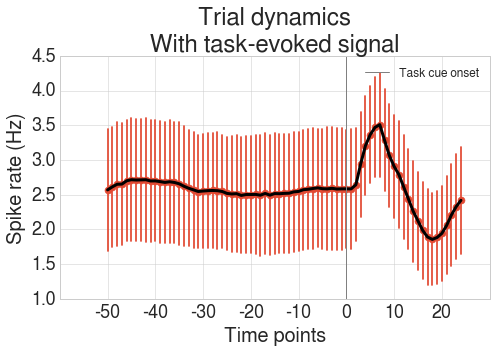

In [281]:
plt.figure(figsize=(7,5));
sns.regplot(x="Time point", y="Spike rate", data=df_mean, x_ci='sd', x_estimator=np.mean,fit_reg=False);
plt.plot(staByTask[preonset:postoffset],'k',linewidth=3)
plt.axvline(x=preonsetdur,color='gray',label='Task cue onset');
# plt.axvline(x=len(block_avg)-offsetlag,color='gray',label='Block onset/offset');
# plt.axvline(x=onset_prestim+7,color='blue');
# plt.axvline(x=len(block_avg)-offsetlag+7,color='blue',label='After HRF correction');
plt.xticks(np.arange(0,postoffset-preonset+1,10),np.arange(-preonsetdur,cueduration+postoffsetdur+1,10));
plt.legend();
plt.xlabel('Time points',fontsize=20);
plt.ylabel('Spike rate (Hz)',fontsize=20);
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Trial dynamics\nWith task-evoked signal',fontsize=24);
plt.tight_layout()

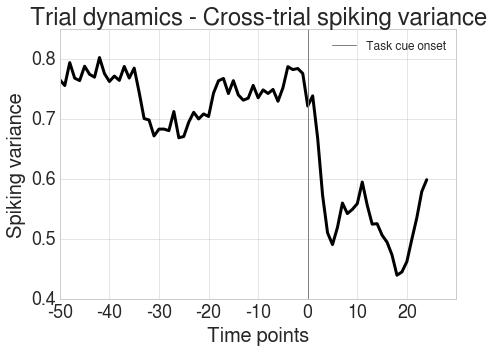

In [279]:
###
trial_periods = {}
trial_periods['Time point'] = []
trial_periods['Spike rate'] = []
trial_periods['Trial number'] = []
trial_avg = []
roi = 0 

trials = sta_removed.shape[1]
for i in range(data.shape[1]):

    trial_periods['Trial number'].extend(np.repeat(i+1,sta_removed.shape[0]))
    trial_periods['Time point'].extend(np.arange(sta_removed.shape[0]))
    trial_periods['Spike rate'].extend(sta_removed[:,i])

df_nomean = pd.DataFrame(trial_periods)

plt.figure(figsize=(7,5));
# sns.regplot(x="Time point", y="Spike rate", data=df_nomean, x_ci='sd', x_estimator=np.mean,fit_reg=False);
plt.plot(np.var(data,axis=1),'k',linewidth=3)
plt.axvline(x=preonsetdur,color='gray',label='Task cue onset');
# plt.axvline(x=len(block_avg)-offsetlag,color='gray',label='Block onset/offset');
# plt.axvline(x=onset_prestim+7,color='blue');
# plt.axvline(x=len(block_avg)-offsetlag+7,color='blue',label='After HRF correction');
plt.xticks(np.arange(0,postoffset-preonset+1,10),np.arange(-preonsetdur,cueduration+postoffsetdur+1,10));
plt.legend();
plt.xlabel('Time points',fontsize=20);
plt.ylabel('Spiking variance',fontsize=20);
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Trial dynamics - Cross-trial spiking variance',fontsize=24);
plt.tight_layout()

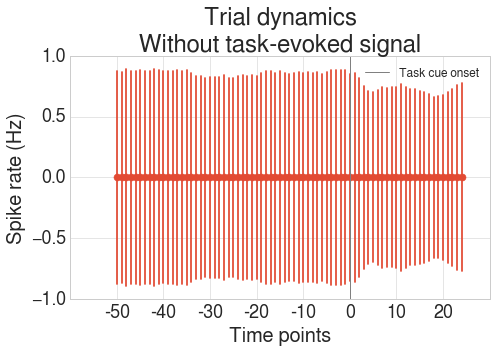

In [282]:
###
trial_periods = {}
trial_periods['Time point'] = []
trial_periods['Spike rate'] = []
trial_periods['Trial number'] = []
trial_avg = []
roi = 0 

trials = sta_removed.shape[1]
for i in range(data.shape[1]):

    trial_periods['Trial number'].extend(np.repeat(i+1,sta_removed.shape[0]))
    trial_periods['Time point'].extend(np.arange(sta_removed.shape[0]))
    trial_periods['Spike rate'].extend(sta_removed[:,i])

df_nomean = pd.DataFrame(trial_periods)

plt.figure(figsize=(7,5));
sns.regplot(x="Time point", y="Spike rate", data=df_nomean, x_ci='sd', x_estimator=np.mean,fit_reg=False);
plt.axvline(x=preonsetdur,color='gray',label='Task cue onset');
# plt.plot(staByTask[preonset:postoffset],'k',linewidth=3)
# plt.axvline(x=onset_prestim,color='gray');
# plt.axvline(x=len(block_avg)-offsetlag,color='gray',label='Block onset/offset');
# plt.axvline(x=onset_prestim+7,color='blue');
# plt.axvline(x=len(block_avg)-offsetlag+7,color='blue',label='After HRF correction');
plt.xticks(np.arange(0,postoffset-preonset+1,10),np.arange(-preonsetdur,cueduration+postoffsetdur+1,10));
plt.legend();
plt.xlabel('Time points',fontsize=20);
plt.ylabel('Spike rate (Hz)',fontsize=20);
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Trial dynamics\nWithout task-evoked signal',fontsize=24);
plt.tight_layout()